# Assignment 2

## Initialization

In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT(RL)/HW02" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Install requirements
!pip install -qr /content/assignment/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

  Preparing metadata (setup.py) ... done


### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import urllib.request

from dataclasses import dataclass
from torch.utils.data import DataLoader
from tqdm import tqdm

from lstm_solution import LSTM
from gpt1_solution import MiniGPT1
from utils.wikitext2 import Wikitext2
from utils.torch_utils import seed_experiment, to_device
from utils.data_utils import save_logs
from run_exp import train, evaluate
import pynvml as nvidia_smi

EMBEDDINGS_URL = "https://www.dropbox.com/s/g91502hubcmb4ob/embeddings.npz?dl=0"

## Public tests
Run the following cell in order to run the public tests to check to tensor shapes of the outputs of your functions.

In [ ]:
!python -m unittest discover -s /content/assignment/

..........
----------------------------------------------------------------------
Ran 10 tests in 0.381s

OK


## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularization, adding logs).

In [ ]:
@dataclass
class Arguments:
  # Data
  data_folder: str = '/content/assignment/data'
  batch_size: int = 16

  # Model
  model: str = 'lstm'  # [lstm, gpt1]
  embeddings: str = '/content/assignment/data/embeddings.npz'
  layers: int = 1

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 10
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  exp_id: str = 'debug'
  log: bool = True
  log_dir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  num_workers: int = 2
  device: str = 'cuda'
  progress_bar: bool = False
  print_every: int = 10

The 12 configurations you need to run in Problem 3. Be careful that there is no discrepency between the configurations defined in `run_exp.py` and the ones below. In case there is a difference, the version from `run_exp.py` should be considered the ones to run.

In [ ]:
# Note: if there is any discrepency with the configurations in run_exp.py, the
# version from run_exp.py should be the ones to use in Problem 3.
configs = {
  1: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adam'),
  2: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  3: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='sgd'),
  4: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='momentum'),

  5: Arguments(model='gpt1', layers=1, batch_size=16, log=True, epochs=10, optimizer='adam'),
  6: Arguments(model='gpt1', layers=1, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  7: Arguments(model='gpt1', layers=1, batch_size=16, log=True, epochs=10, optimizer='sgd'),
  8: Arguments(model='gpt1', layers=1, batch_size=16, log=True, epochs=10, optimizer='momentum'),

  9: Arguments(model='lstm', layers=2, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  10: Arguments(model='lstm', layers=4, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  11: Arguments(model='gpt1', layers=2, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  12: Arguments(model='gpt1', layers=4, batch_size=16, log=True, epochs=10, optimizer='adamw'),
}

In [ ]:
def main(args):
  # Seed the experiment, for repeatability
  seed_experiment(args.seed)

  # Dataloaders
  train_dataset = Wikitext2(args.data_folder, split="train")
  train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
  )

  valid_dataset = Wikitext2(args.data_folder, split="validation")
  valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  test_dataset = Wikitext2(args.data_folder, split="test")
  test_dataloader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  # Download the embeddings
  if not os.path.isfile(args.embeddings):
    print("Downloading embeddings...")
    urllib.request.urlretrieve(EMBEDDINGS_URL, args.embeddings)

  # Model
  if args.model == "lstm":
    model = LSTM.load_embeddings_from(
      args.embeddings, hidden_size=512, num_layers=args.layers
    )
  elif args.model == "gpt1":
    model = MiniGPT1.load_embeddings_from(
      args.embeddings, num_layers=args.layers
    )
  else:
    raise ValueError("Unknown model {0}".format(args.model))
  model.to(args.device)

  # Optimizer
  if args.optimizer == "adamw":
    optimizer = optim.AdamW(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
  elif args.optimizer == "sgd":
    optimizer = optim.SGD(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "momentum":
    optimizer = optim.SGD(
      model.parameters(),
      lr=args.lr,
      momentum=args.momentum,
      weight_decay=args.weight_decay,
    )

  print(
    f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
    f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
  )

  train_losses, valid_losses = [], []
  train_ppls, valid_ppls = [], []
  train_times, valid_times = [], []
  memory=[]
  for epoch in range(args.epochs):

    tqdm.write(f"====== Epoch {epoch} ======>")
    # device1 = torch.device('cuda')
    # # torch.cuda.reset_peak_memory_stats(device=device1)

    loss, ppl, wall_time = train(epoch, model, train_dataloader, optimizer, args)
    train_losses.append(loss)
    train_ppls.append(ppl)
    train_times.append(wall_time)
    # print("memory:")


    # peak_memory_usage_bytes = torch.cuda.max_memory_allocated(device=device1)
    # peak_memory_usage_gb = peak_memory_usage_bytes / (2**30)
    # print(f" Peak GPU memory usage: {peak_memory_usage_gb:.2f} GB")
    # torch.cuda.reset_peak_memory_stats(device=device1)
    nvidia_smi.nvmlInit()
    deviceCount = nvidia_smi.nvmlDeviceGetCount()

    # Specify the file path where you want to save the output
    output_file_path = 'gpu_memory_used.txt'
    used_memory_gb=0
    with open(output_file_path, 'a') as file:
        for i in range(deviceCount):
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            used_memory_gb = info.used / (1024**3)
            memory.append(used_memory_gb)
            memory_log = "Device {}: Used Memory: {:.2f} GB\n".format(i, used_memory_gb)

            file.write(memory_log)

    nvidia_smi.nvmlShutdown()
    print("memory:")
    print(used_memory_gb)

    loss, ppl, wall_time = evaluate(epoch, model, valid_dataloader, args)
    valid_losses.append(loss)
    valid_ppls.append(ppl)
    valid_times.append(wall_time)


  test_loss, test_ppl, test_time = evaluate(
    epoch, model, test_dataloader, args, mode="test"
  )

  print(f"===== Best validation perplexity: {min(valid_ppls):.3f} =====>")

  return (
    train_losses,
    train_ppls,
    train_times,
    valid_losses,
    valid_ppls,
    valid_times,
    test_loss,
    test_ppl,
    test_time,
  )

## Exp 1

In [ ]:
args = configs[1]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.51239
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.83983
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.61644
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.55055
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.57284
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.42144
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.38435
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.25443
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.32316
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.20074
[TRAIN] Epoch: 0, Iter: 110, Loss: 6.99470
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.15956
[TRAIN] Epoch: 0, Iter: 130, Loss: 6.88057
[TRAIN] Epoch: 0, Iter: 140, Loss: 6.87990
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.69255
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.85624
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.82822
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.59956
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.66666
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.561

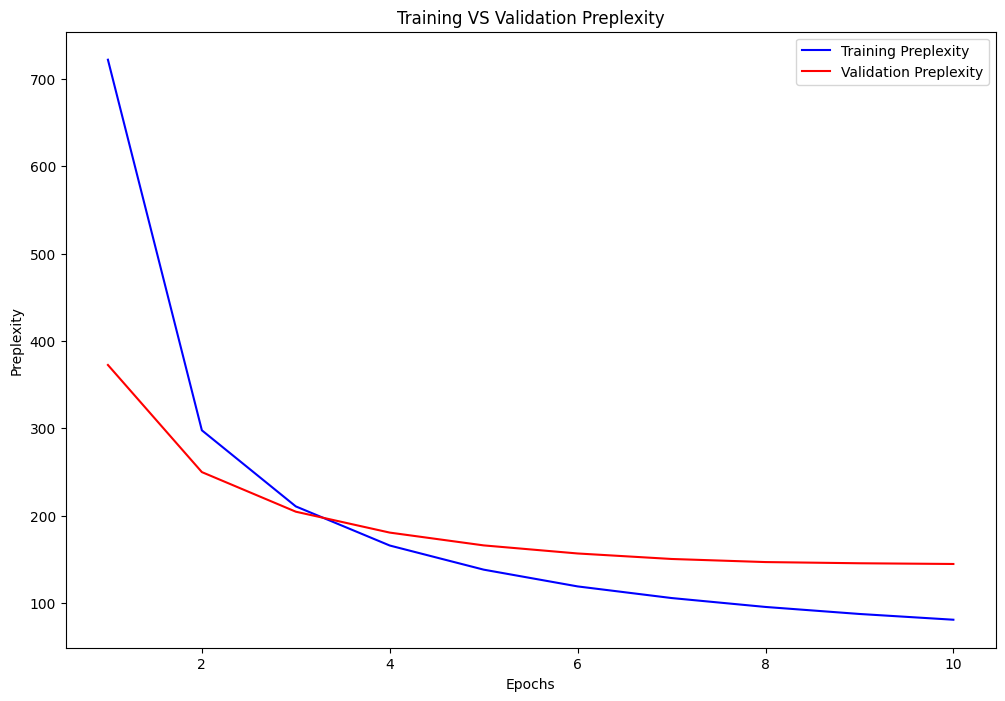

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()


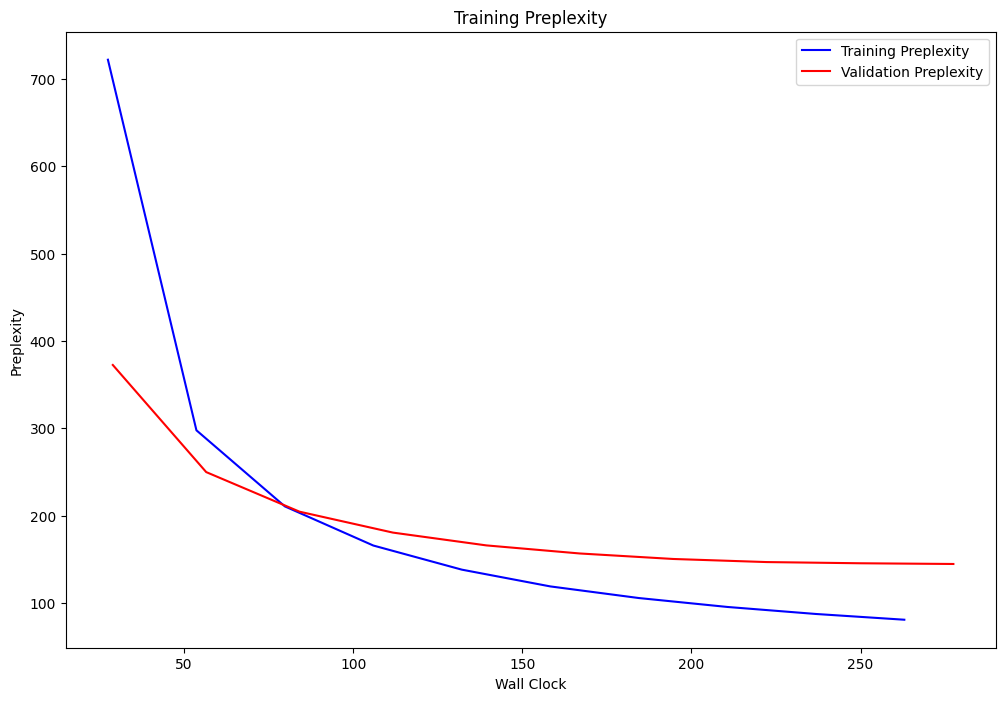

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 2

In [ ]:
args = configs[2]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.51241
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.83985
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.61654
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.55066
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.57290
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.42141
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.38439
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.25474
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.32162
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.19921
[TRAIN] Epoch: 0, Iter: 110, Loss: 6.99357
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.15701
[TRAIN] Epoch: 0, Iter: 130, Loss: 6.88103
[TRAIN] Epoch: 0, Iter: 140, Loss: 6.87688
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.69043
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.87009
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.82589
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.60110
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.66654
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.566

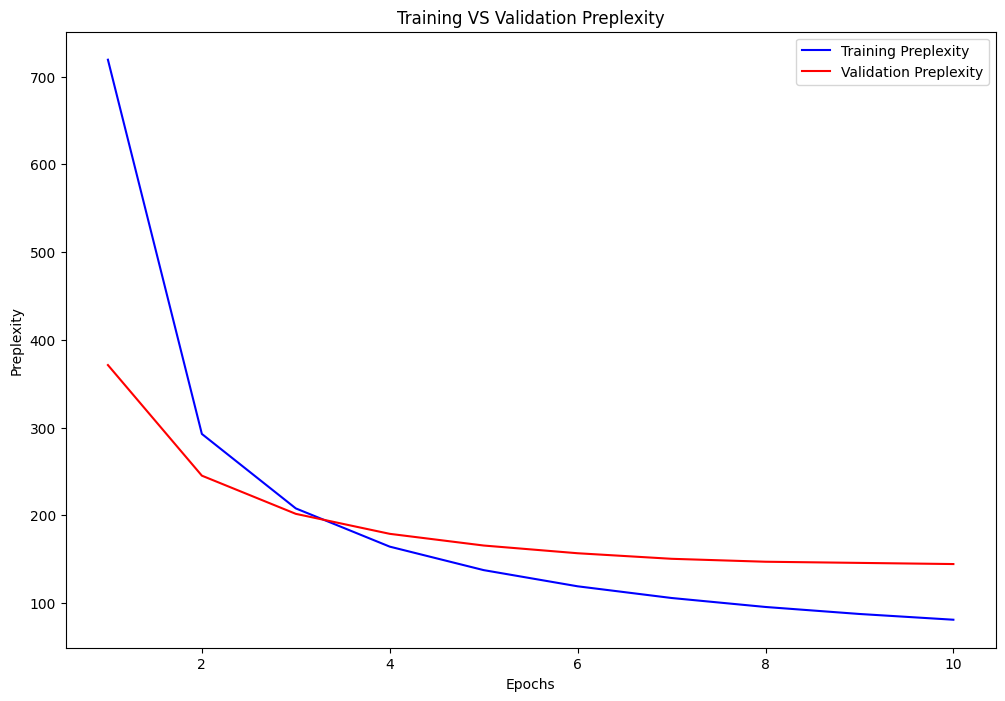

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

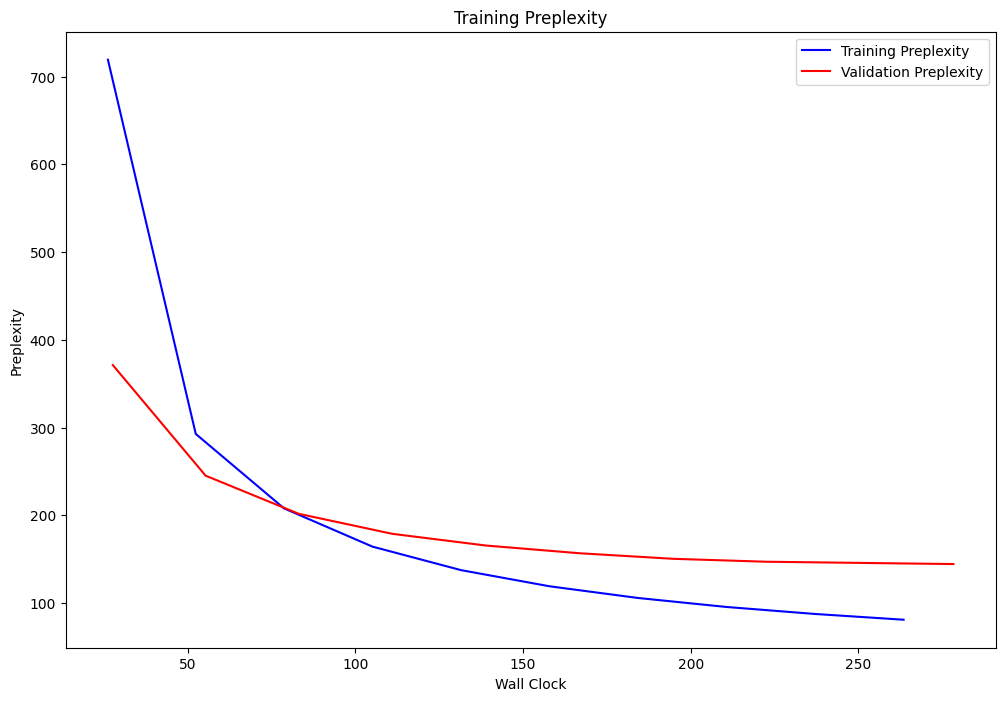

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 3

In [ ]:
args = configs[3]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 10.60043
[TRAIN] Epoch: 0, Iter: 20, Loss: 10.59470
[TRAIN] Epoch: 0, Iter: 30, Loss: 10.58981
[TRAIN] Epoch: 0, Iter: 40, Loss: 10.58366
[TRAIN] Epoch: 0, Iter: 50, Loss: 10.57872
[TRAIN] Epoch: 0, Iter: 60, Loss: 10.57168
[TRAIN] Epoch: 0, Iter: 70, Loss: 10.56722
[TRAIN] Epoch: 0, Iter: 80, Loss: 10.56237
[TRAIN] Epoch: 0, Iter: 90, Loss: 10.55735
[TRAIN] Epoch: 0, Iter: 100, Loss: 10.55134
[TRAIN] Epoch: 0, Iter: 110, Loss: 10.54614
[TRAIN] Epoch: 0, Iter: 120, Loss: 10.54164
[TRAIN] Epoch: 0, Iter: 130, Loss: 10.53424
[TRAIN] Epoch: 0, Iter: 140, Loss: 10.52969
[TRAIN] Epoch: 0, Iter: 150, Loss: 10.52247
[TRAIN] Epoch: 0, Iter: 160, Loss: 10.52107
[TRAIN] Epoch: 0, Iter: 170, Loss: 10.51572
[TRAIN] Epoch: 0, Iter: 180, Loss: 10.50896
[TRAIN] Epoch: 0, Iter: 190, Loss: 10.50788
[TRAIN] Epoch: 0, Ite

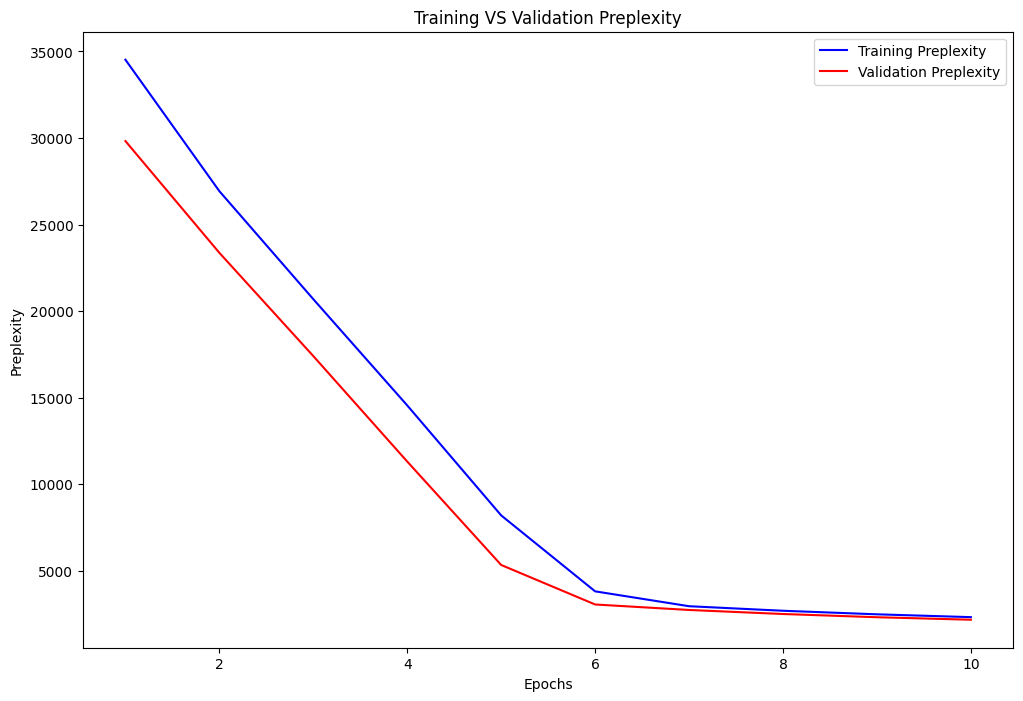

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

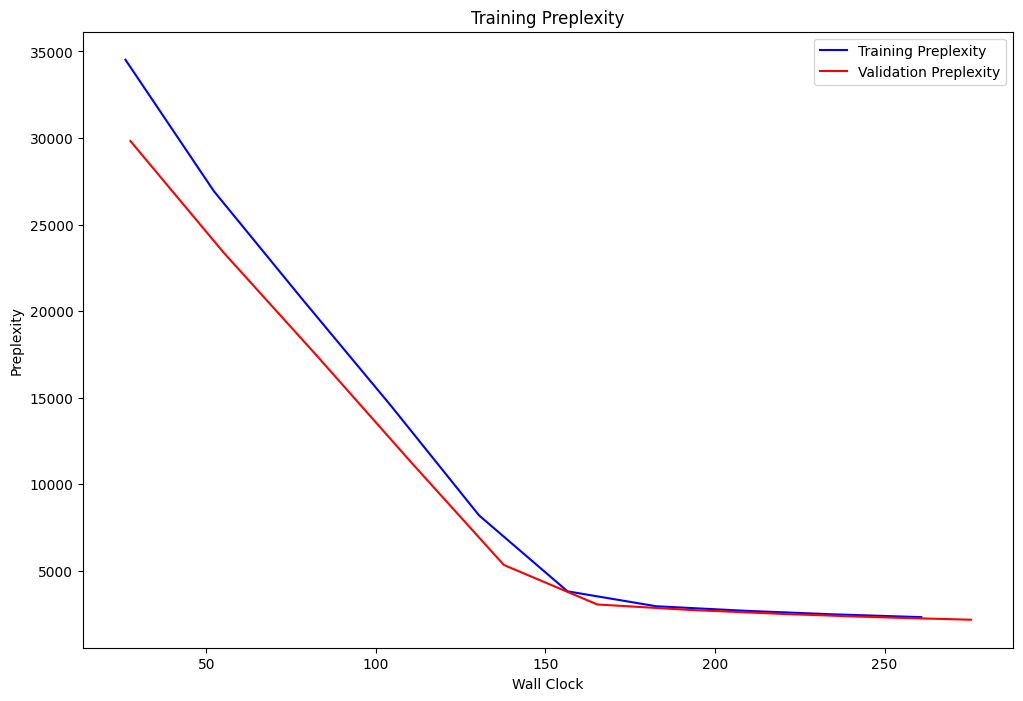

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 4

In [ ]:
args = configs[4]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 10.58283
[TRAIN] Epoch: 0, Iter: 20, Loss: 10.54029
[TRAIN] Epoch: 0, Iter: 30, Loss: 10.49174
[TRAIN] Epoch: 0, Iter: 40, Loss: 10.44528
[TRAIN] Epoch: 0, Iter: 50, Loss: 10.40898
[TRAIN] Epoch: 0, Iter: 60, Loss: 10.36127
[TRAIN] Epoch: 0, Iter: 70, Loss: 10.32264
[TRAIN] Epoch: 0, Iter: 80, Loss: 10.28657
[TRAIN] Epoch: 0, Iter: 90, Loss: 10.24958
[TRAIN] Epoch: 0, Iter: 100, Loss: 10.20651
[TRAIN] Epoch: 0, Iter: 110, Loss: 10.16867
[TRAIN] Epoch: 0, Iter: 120, Loss: 10.13302
[TRAIN] Epoch: 0, Iter: 130, Loss: 10.07550
[TRAIN] Epoch: 0, Iter: 140, Loss: 10.03706
[TRAIN] Epoch: 0, Iter: 150, Loss: 9.97491
[TRAIN] Epoch: 0, Iter: 160, Loss: 9.95932
[TRAIN] Epoch: 0, Iter: 170, Loss: 9.90280
[TRAIN] Epoch: 0, Iter: 180, Loss: 9.83099
[TRAIN] Epoch: 0, Iter: 190, Loss: 9.81463
[TRAIN] Epoch: 0, Iter: 20

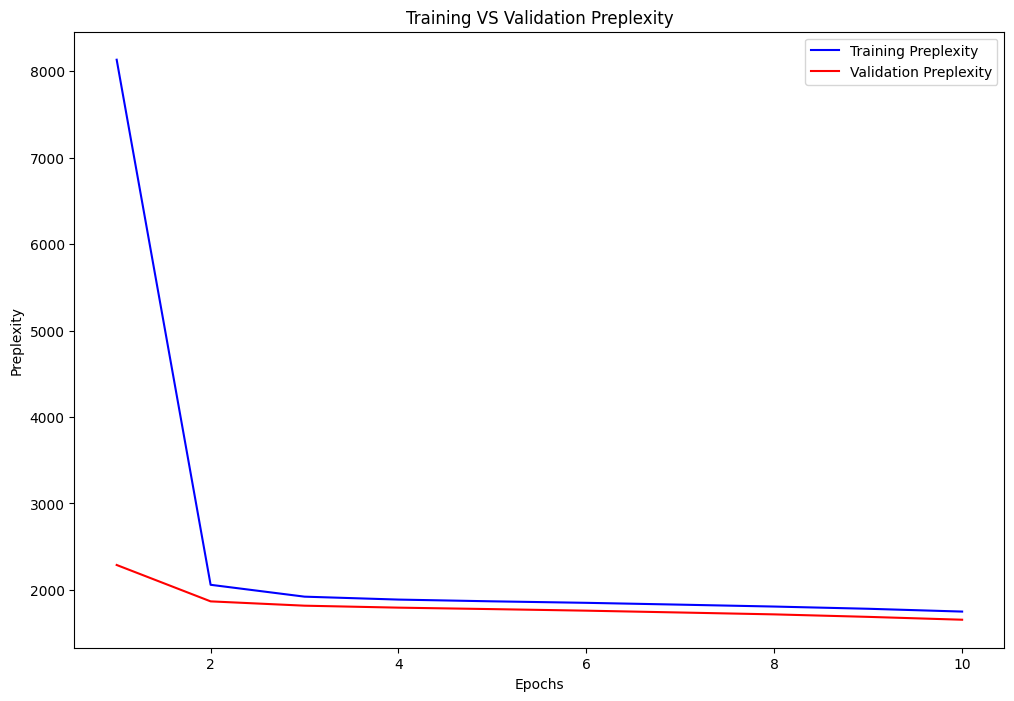

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

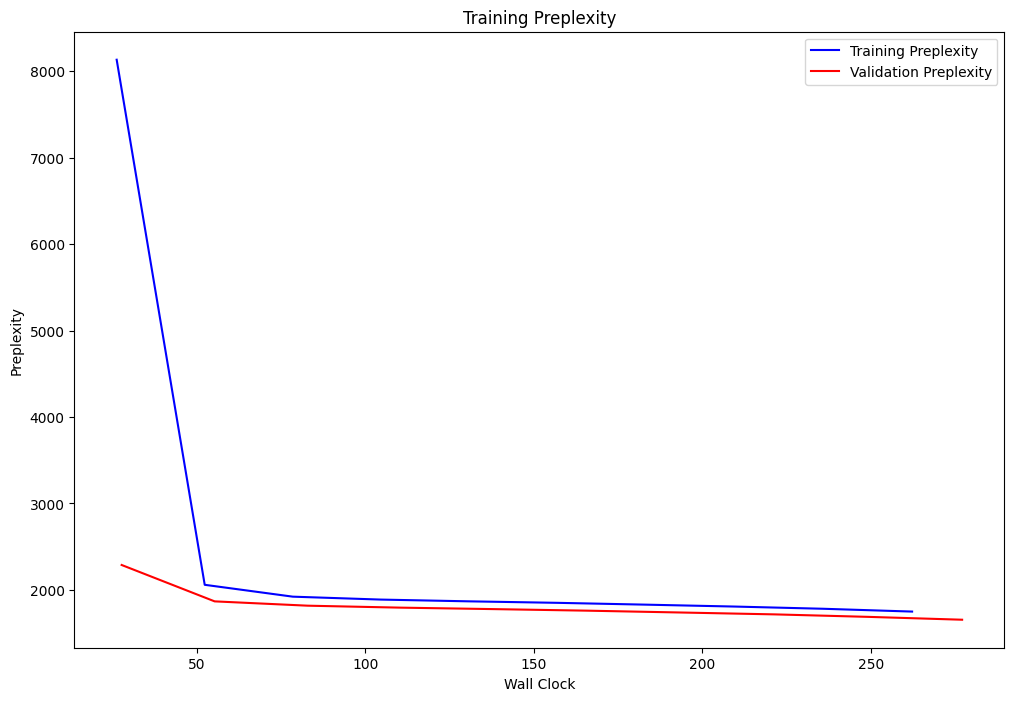

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 5

In [ ]:
args = configs[5]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized GPT1 model with 38372352 total parameters, of which 7087872 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 47.94060
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.99261
[TRAIN] Epoch: 0, Iter: 20, Loss: 8.25693
[TRAIN] Epoch: 0, Iter: 30, Loss: 8.18635
[TRAIN] Epoch: 0, Iter: 40, Loss: 8.00987
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.93609
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.80059
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.64447
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.78040
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.62280
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.62948
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.56189
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.35018
[TRAIN] Epoch: 0, Iter: 130, Loss: 7.15963
[TRAIN] Epoch: 0, Iter: 140, Loss: 7.21811
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.97192
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.97029
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.77683
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.81559
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.71226
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.644

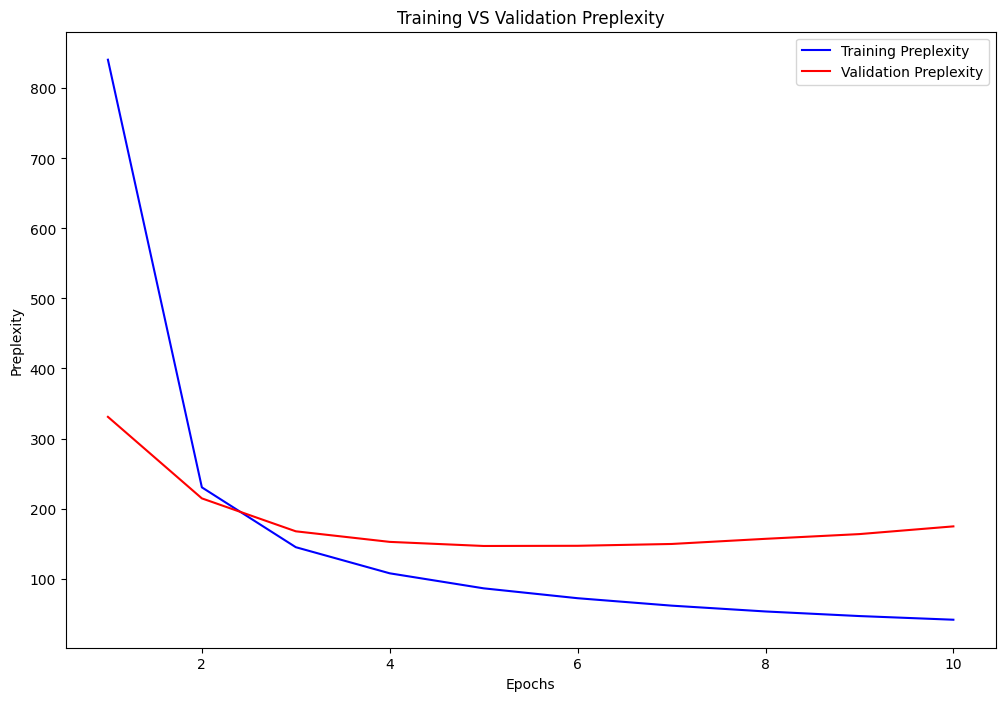

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

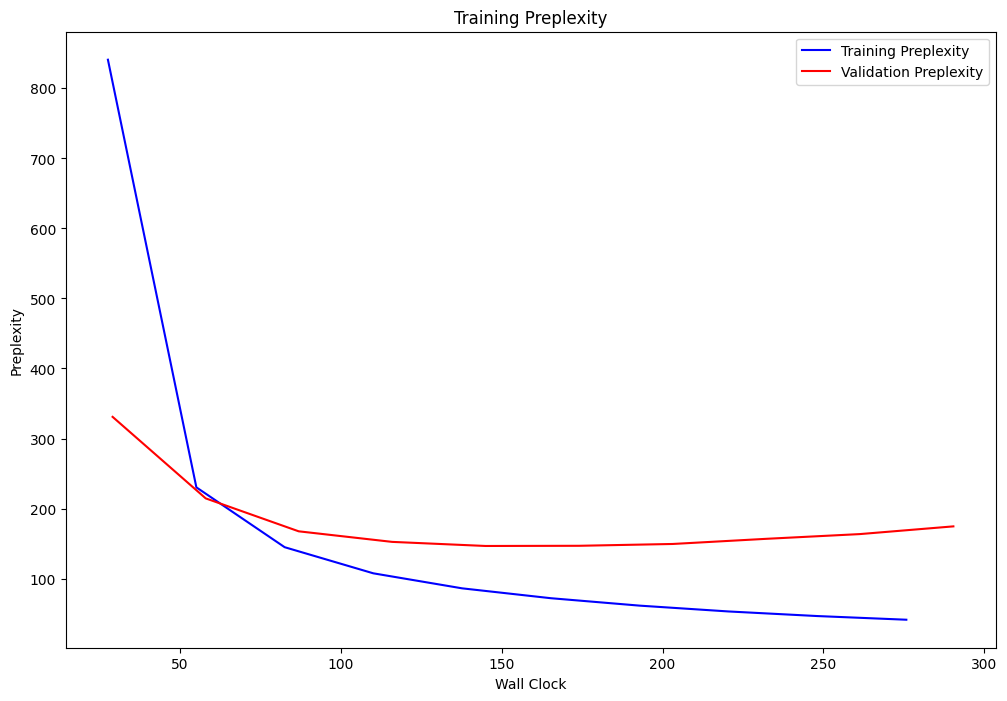

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 6

In [ ]:
args = configs[6]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized GPT1 model with 38372352 total parameters, of which 7087872 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 47.94060
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.99259
[TRAIN] Epoch: 0, Iter: 20, Loss: 8.25692
[TRAIN] Epoch: 0, Iter: 30, Loss: 8.18633
[TRAIN] Epoch: 0, Iter: 40, Loss: 8.00984
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.93606
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.80055
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.64443
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.78036
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.62276
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.62943
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.56201
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.35035
[TRAIN] Epoch: 0, Iter: 130, Loss: 7.16013
[TRAIN] Epoch: 0, Iter: 140, Loss: 7.21912
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.97356
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.96884
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.77652
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.81543
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.71304
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.645

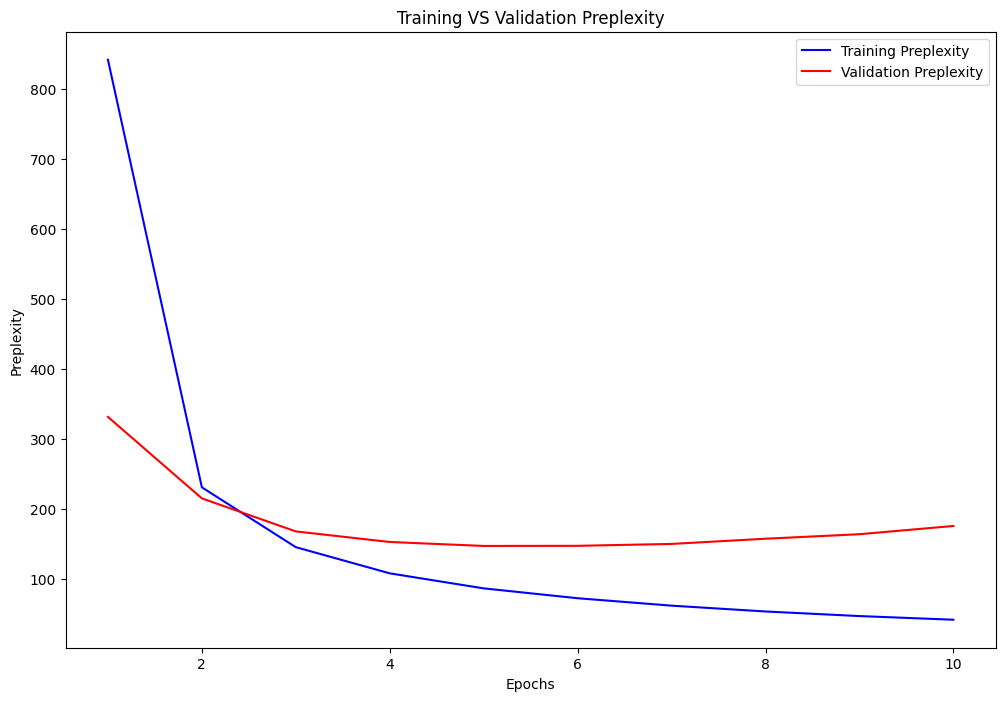

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

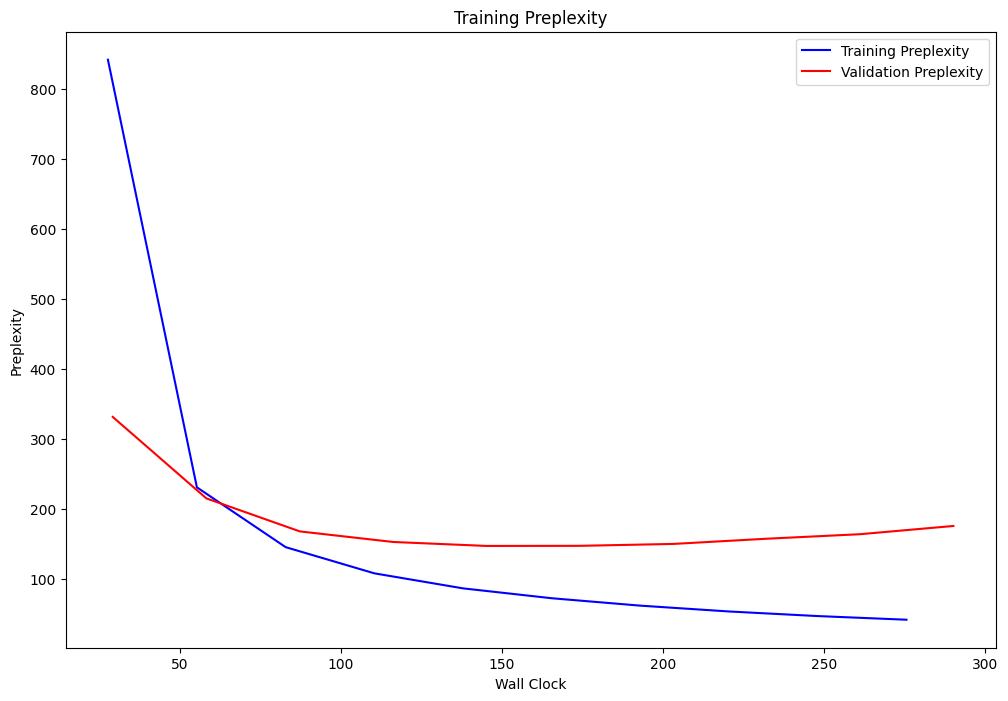

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 7

In [ ]:
args = configs[7]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized GPT1 model with 38372352 total parameters, of which 7087872 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 47.94060
[TRAIN] Epoch: 0, Iter: 10, Loss: 46.47384
[TRAIN] Epoch: 0, Iter: 20, Loss: 43.07013
[TRAIN] Epoch: 0, Iter: 30, Loss: 40.47357
[TRAIN] Epoch: 0, Iter: 40, Loss: 36.51553
[TRAIN] Epoch: 0, Iter: 50, Loss: 33.02962
[TRAIN] Epoch: 0, Iter: 60, Loss: 29.49001
[TRAIN] Epoch: 0, Iter: 70, Loss: 25.64249
[TRAIN] Epoch: 0, Iter: 80, Loss: 22.96433
[TRAIN] Epoch: 0, Iter: 90, Loss: 20.07623
[TRAIN] Epoch: 0, Iter: 100, Loss: 17.77889
[TRAIN] Epoch: 0, Iter: 110, Loss: 15.78642
[TRAIN] Epoch: 0, Iter: 120, Loss: 14.19236
[TRAIN] Epoch: 0, Iter: 130, Loss: 13.09069
[TRAIN] Epoch: 0, Iter: 140, Loss: 12.29716
[TRAIN] Epoch: 0, Iter: 150, Loss: 11.53777
[TRAIN] Epoch: 0, Iter: 160, Loss: 11.00247
[TRAIN] Epoch: 0, Iter: 170, Loss: 10.62517
[TRAIN] Epoch: 0, Iter: 180, Loss: 10.32860
[TRAIN] Epoch: 0, Iter: 190, Loss: 10.18943
[TRAIN] Epoch: 0, Ite

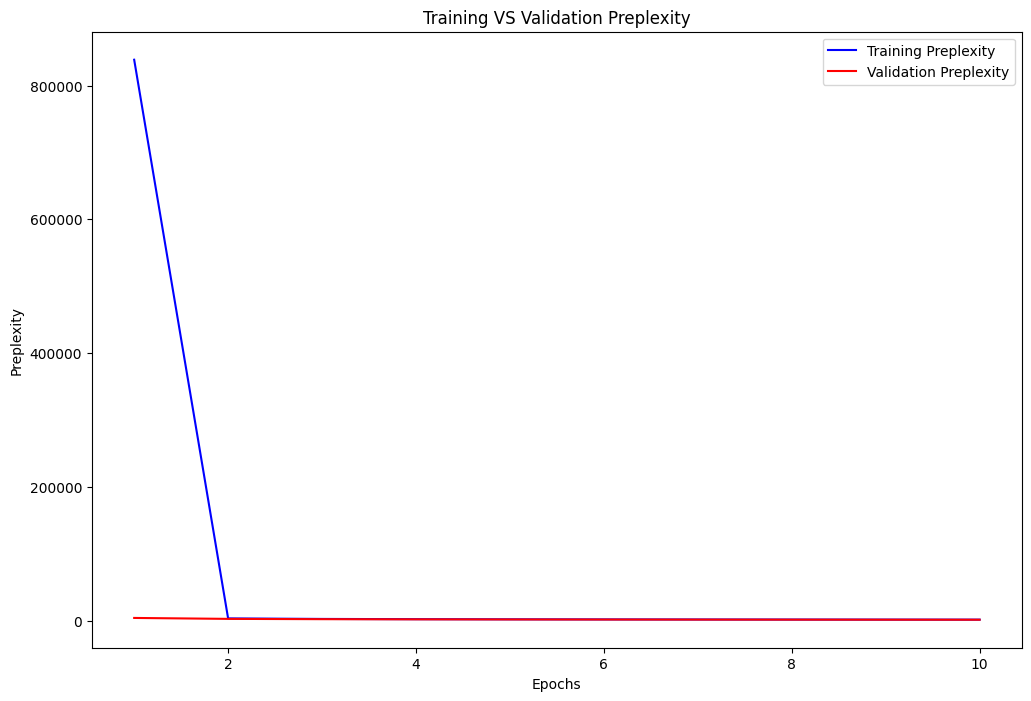

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

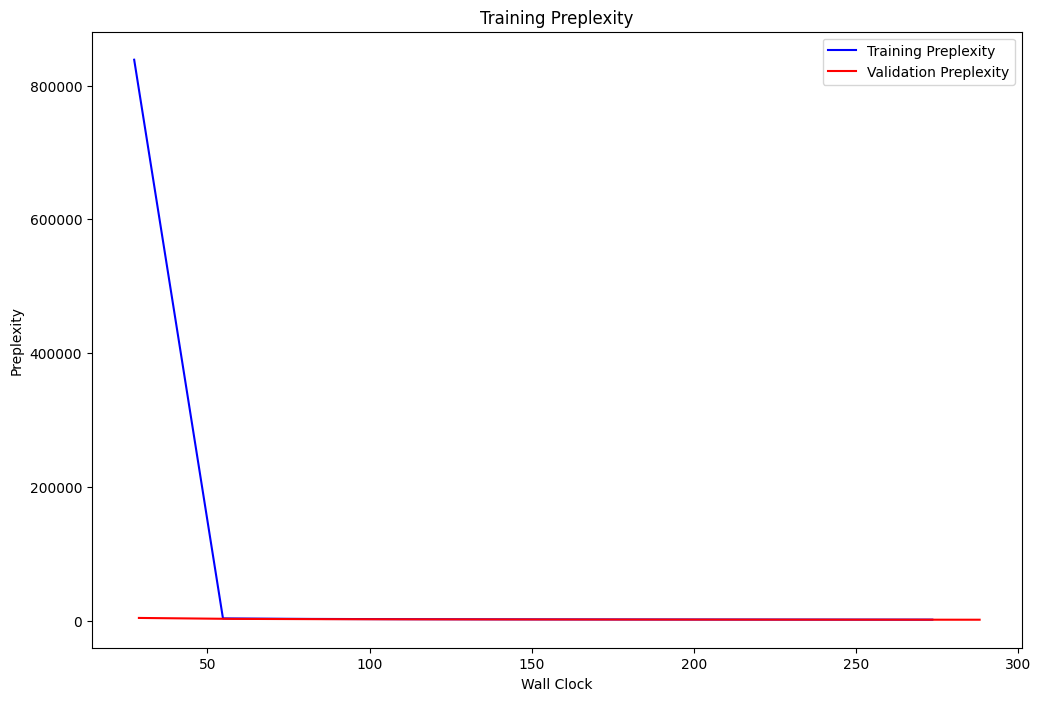

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 8

In [ ]:
args = configs[8]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized GPT1 model with 38372352 total parameters, of which 7087872 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 47.94060
[TRAIN] Epoch: 0, Iter: 10, Loss: 38.27870
[TRAIN] Epoch: 0, Iter: 20, Loss: 19.41688
[TRAIN] Epoch: 0, Iter: 30, Loss: 9.77405
[TRAIN] Epoch: 0, Iter: 40, Loss: 9.29147
[TRAIN] Epoch: 0, Iter: 50, Loss: 8.70444
[TRAIN] Epoch: 0, Iter: 60, Loss: 8.41044
[TRAIN] Epoch: 0, Iter: 70, Loss: 8.22163
[TRAIN] Epoch: 0, Iter: 80, Loss: 8.39498
[TRAIN] Epoch: 0, Iter: 90, Loss: 8.26770
[TRAIN] Epoch: 0, Iter: 100, Loss: 8.23705
[TRAIN] Epoch: 0, Iter: 110, Loss: 8.19308
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.98843
[TRAIN] Epoch: 0, Iter: 130, Loss: 7.90194
[TRAIN] Epoch: 0, Iter: 140, Loss: 8.11017
[TRAIN] Epoch: 0, Iter: 150, Loss: 7.93928
[TRAIN] Epoch: 0, Iter: 160, Loss: 8.08524
[TRAIN] Epoch: 0, Iter: 170, Loss: 7.96342
[TRAIN] Epoch: 0, Iter: 180, Loss: 8.00199
[TRAIN] Epoch: 0, Iter: 190, Loss: 8.00268
[TRAIN] Epoch: 0, Iter: 200, Loss: 7.9

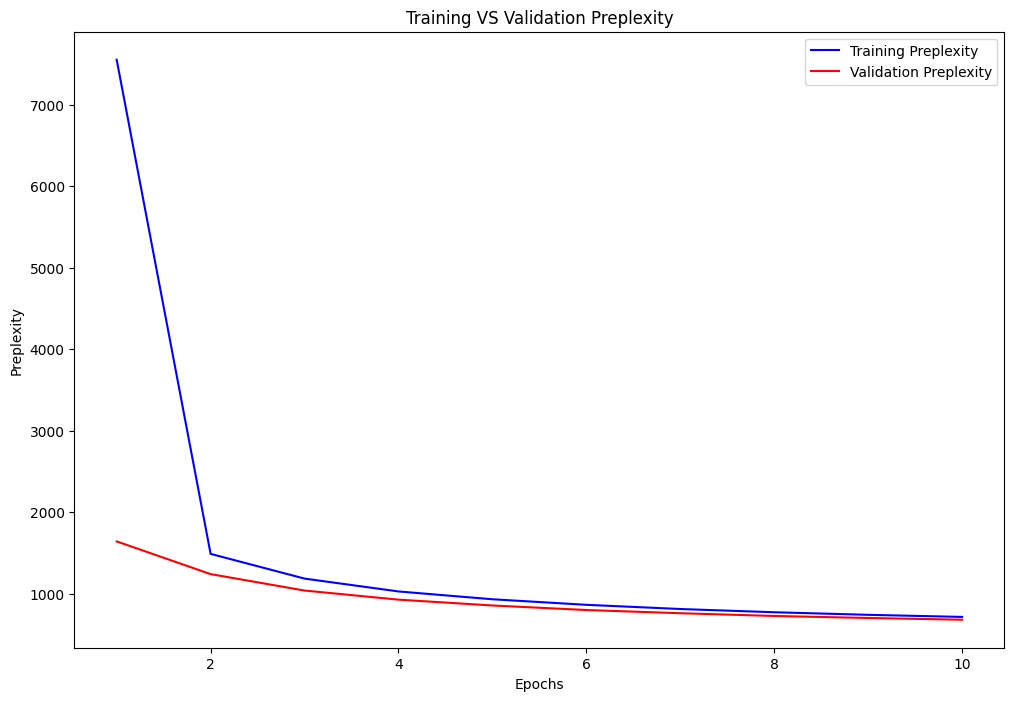

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

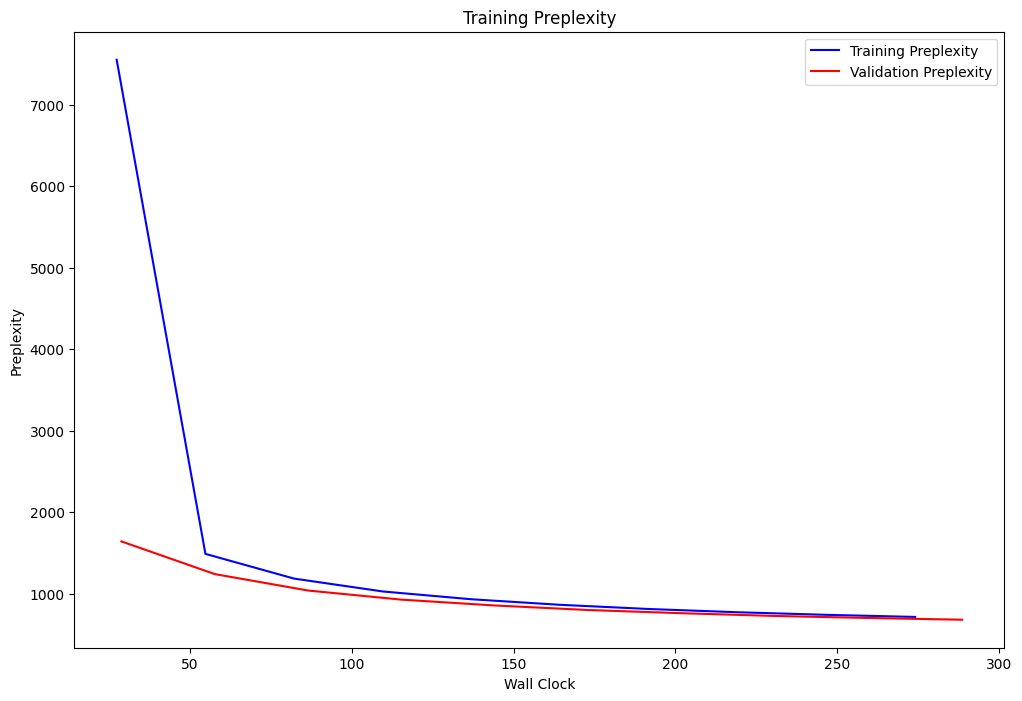

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 9

In [ ]:
args = configs[9]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized LSTM model with 36208640 total parameters, of which 5120768 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.61653
[TRAIN] Epoch: 0, Iter: 10, Loss: 7.81739
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.72222
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.57045
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.62680
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.56064
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.41076
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.48390
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.35696
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.32212
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.04630
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.03697
[TRAIN] Epoch: 0, Iter: 120, Loss: 6.97153
[TRAIN] Epoch: 0, Iter: 130, Loss: 6.82799
[TRAIN] Epoch: 0, Iter: 140, Loss: 6.75350
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.88678
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.73464
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.54951
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.66676
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.62199
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.735

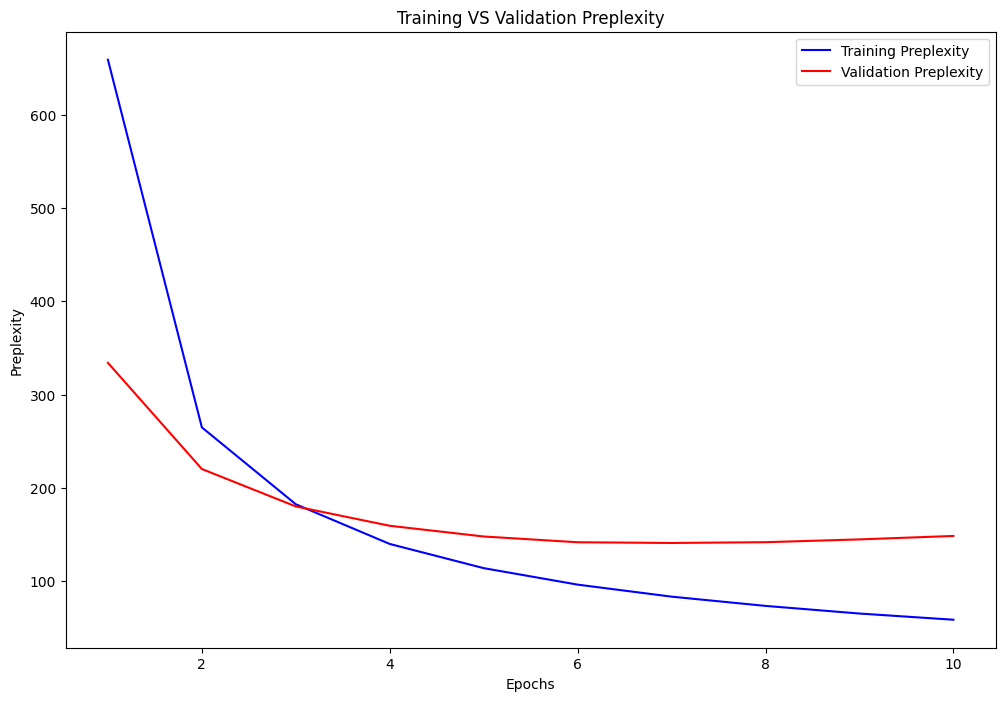

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

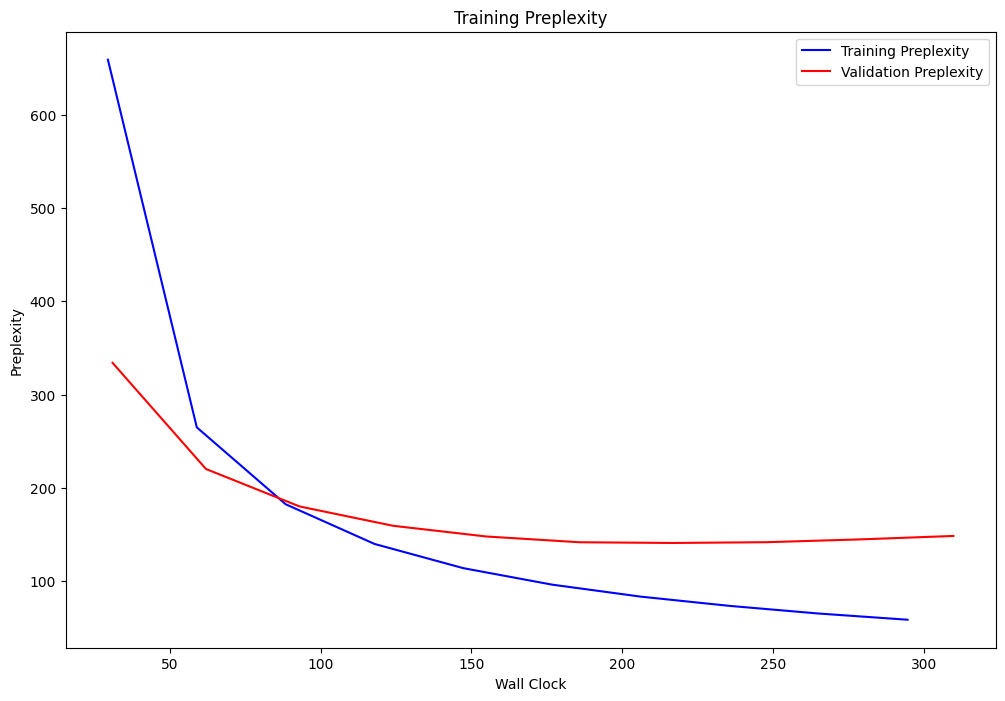

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 10

In [ ]:
args = configs[10]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized LSTM model with 40411136 total parameters, of which 9323264 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.63803
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.12584
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.78245
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.65453
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.64762
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.63025
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.65209
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.64483
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.69085
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.60191
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.59715
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.48292
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.51568
[TRAIN] Epoch: 0, Iter: 130, Loss: 7.51020
[TRAIN] Epoch: 0, Iter: 140, Loss: 7.45340
[TRAIN] Epoch: 0, Iter: 150, Loss: 7.40906
[TRAIN] Epoch: 0, Iter: 160, Loss: 7.26932
[TRAIN] Epoch: 0, Iter: 170, Loss: 7.35465
[TRAIN] Epoch: 0, Iter: 180, Loss: 7.36042
[TRAIN] Epoch: 0, Iter: 190, Loss: 7.30636
[TRAIN] Epoch: 0, Iter: 200, Loss: 7.213

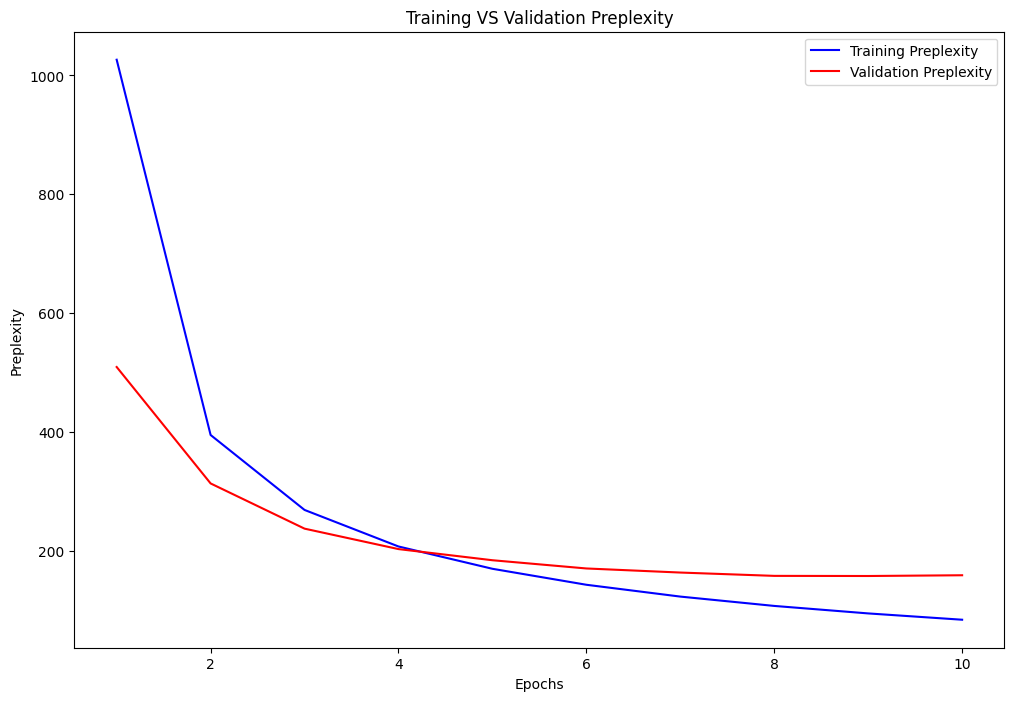

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

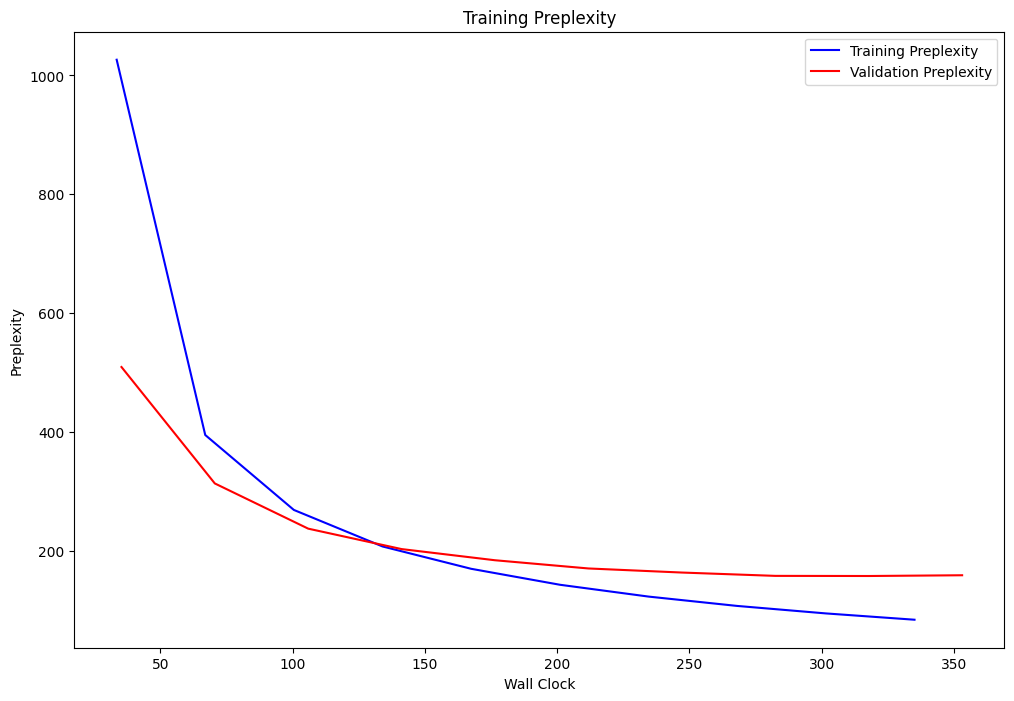

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 11

In [ ]:
args = configs[11]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized GPT1 model with 45460224 total parameters, of which 14175744 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 46.66715
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.62355
[TRAIN] Epoch: 0, Iter: 20, Loss: 8.11012
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.86936
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.91982
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.89487
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.77159
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.62268
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.59042
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.60598
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.52208
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.48137
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.48590
[TRAIN] Epoch: 0, Iter: 130, Loss: 7.44462
[TRAIN] Epoch: 0, Iter: 140, Loss: 7.47346
[TRAIN] Epoch: 0, Iter: 150, Loss: 7.38180
[TRAIN] Epoch: 0, Iter: 160, Loss: 7.42033
[TRAIN] Epoch: 0, Iter: 170, Loss: 7.52376
[TRAIN] Epoch: 0, Iter: 180, Loss: 7.27703
[TRAIN] Epoch: 0, Iter: 190, Loss: 7.39368
[TRAIN] Epoch: 0, Iter: 200, Loss: 7.38

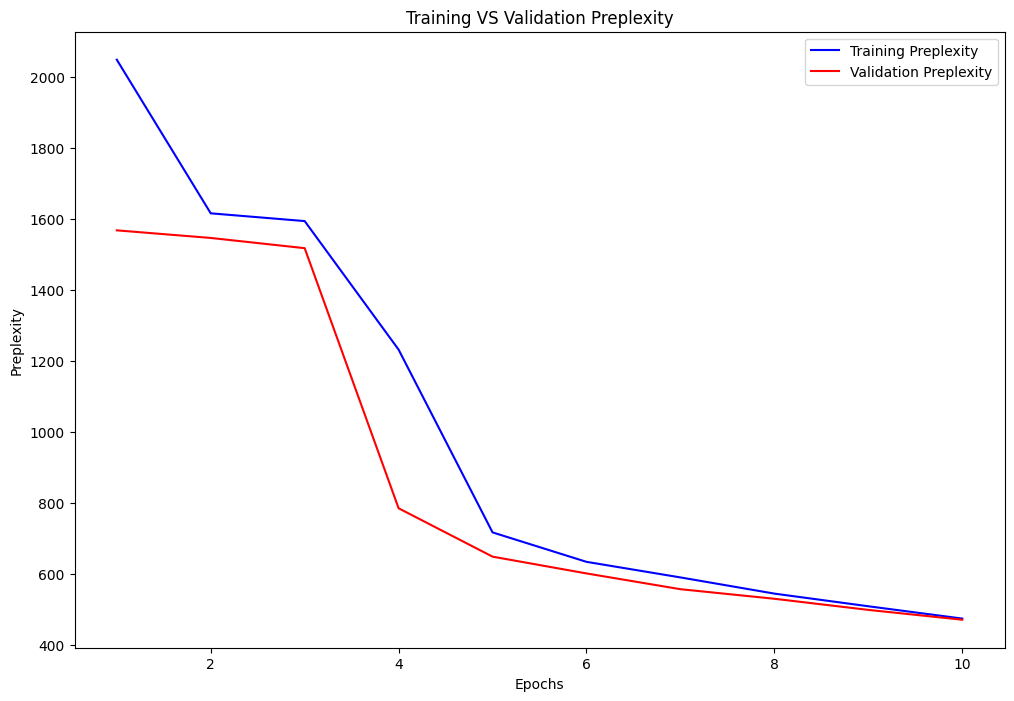

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

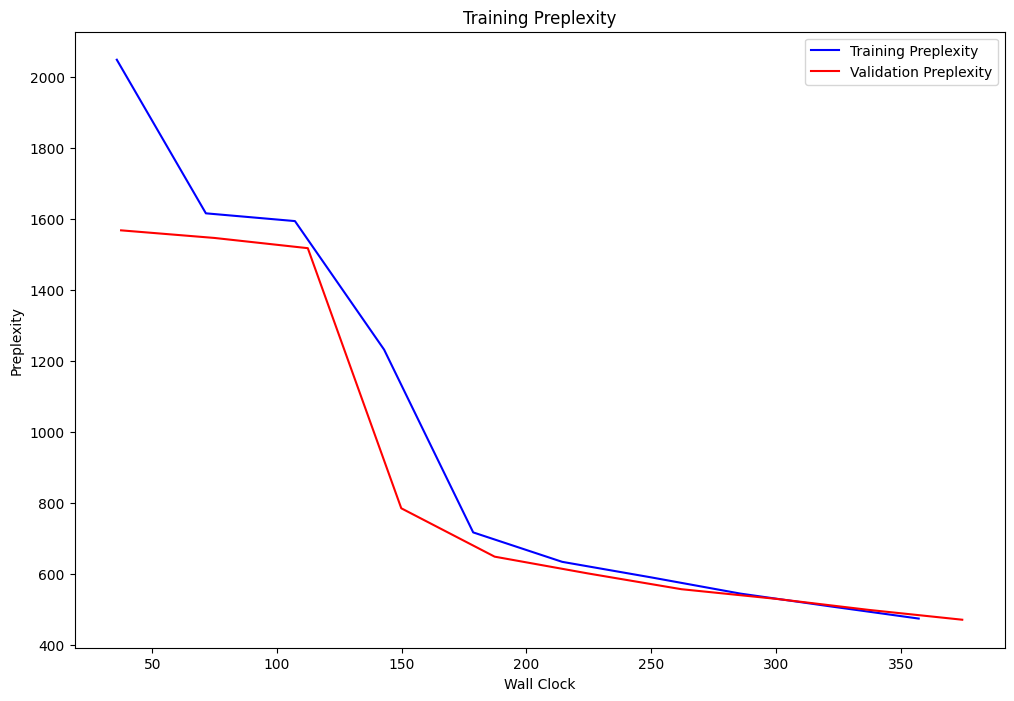

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();

# Exp 12

In [ ]:
args = configs[12]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

Initialized GPT1 model with 59635968 total parameters, of which 28351488 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 43.99664
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.26890
[TRAIN] Epoch: 0, Iter: 20, Loss: 8.02765
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.85310
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.85831
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.64147
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.82989
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.57783
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.60149
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.64330
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.65699
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.58611
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.40732
[TRAIN] Epoch: 0, Iter: 130, Loss: 7.58392
[TRAIN] Epoch: 0, Iter: 140, Loss: 7.50507
[TRAIN] Epoch: 0, Iter: 150, Loss: 7.45276
[TRAIN] Epoch: 0, Iter: 160, Loss: 7.33069
[TRAIN] Epoch: 0, Iter: 170, Loss: 7.54278
[TRAIN] Epoch: 0, Iter: 180, Loss: 7.48173
[TRAIN] Epoch: 0, Iter: 190, Loss: 7.46101
[TRAIN] Epoch: 0, Iter: 200, Loss: 7.23

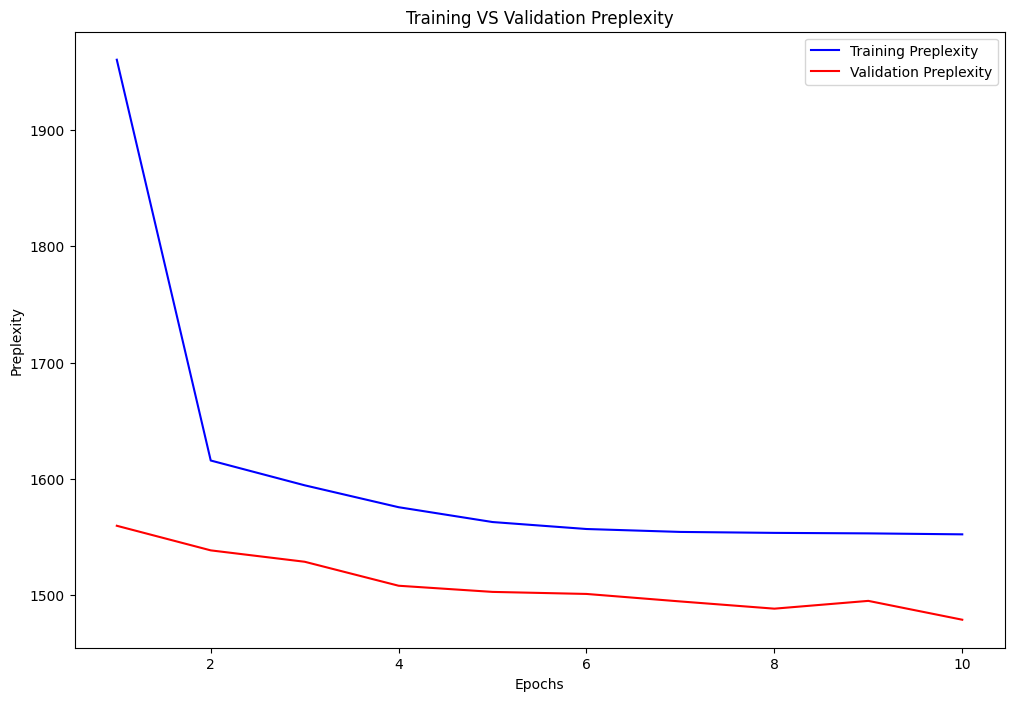

In [ ]:
epochs=np.arange(1, 11)
plt.figure(figsize=(12, 8))
plt.plot(epochs, logs[1], label='Training Preplexity', color='blue')
plt.plot(epochs, logs[4], label='Validation Preplexity', color='red')
plt.title('Training VS Validation Preplexity')
plt.xlabel('Epochs')
plt.ylabel('Preplexity')
plt.legend()

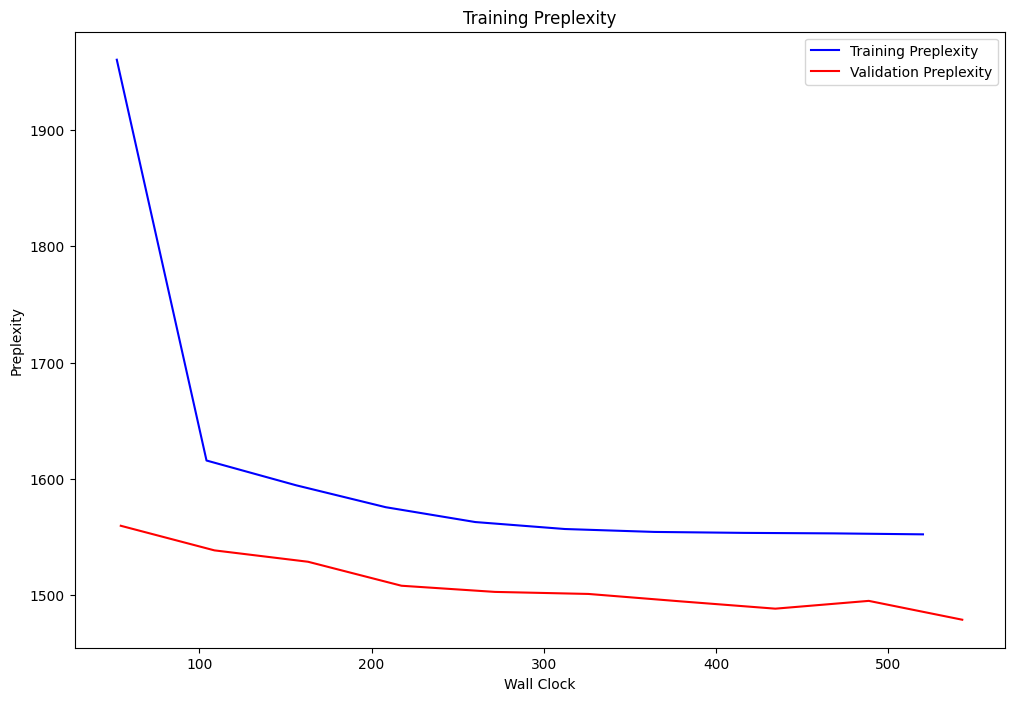

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(logs[2]), logs[1], label='Training Preplexity', color='blue')
result = [a + b for a, b in zip(logs[2], logs[5])]
plt.plot(np.cumsum(result), logs[4], label='Validation Preplexity', color='red')
plt.title('Training Preplexity')
plt.xlabel('Wall Clock')
plt.ylabel('Preplexity')
plt.legend();